## Khai báo thư viện 

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import joblib
# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
# algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
import sklearn

#metrics
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import warnings

%matplotlib inline
# plt.rcParams["figure.figsize"] = (12, 6)
# plt.rcParams['figure.dpi'] = 100

warnings.filterwarnings("ignore")

## Tham số thực nghiệm


In [2]:
k_fold = 5
random_state = 42
# cố định random-state để phục hồi lại kết quả thí nghiệm
random.seed(random_state)
os.environ['PYTHONHASHSEED'] = str(random_state)
np.random.seed(random_state)

## Dữ liệu thực nghiệm (Validation Dataset)
- Tập dữ liệu được chia thành 2 phần train/test với tỉ lệ 7/3 (trong phần preprocessing)
- Tập train được dùng để huấn luyện và điều chỉnh tham số với chiến lược:
    - Hold - out (tiếp tục chia 7/3 với train/valid)
    - f-fold (chia thành k phần đều nhau với k-1 phần cho train/1 phần cho valid)
    - train dùng để huấn luyện và valid dùng điều chỉnh tham số
- Tập test dùng để kiểm nghiệm lại độ hiệu quả của thuật toán sau khi chọn mô hình tối ưu

In [3]:
df = pd.read_csv('../exps/feature1/df_standard.csv')
df

,attr1,attr3,attr4,attr5,attr6,attr7,attr8,attr9,attr10,attr11,...,attr26,attr27,attr28,attr29,attr30,attr31,attr32,attr33,attr34,class
0,1.0,1.000000,0.310810,0.824325,0.648650,0.824325,0.378380,0.932430,0.594595,1.000000,...,0.351350,0.805155,0.389185,0.792390,0.384865,0.864865,0.202705,0.756755,0.378380,1
1,0.0,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.500000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0
2,1.0,1.000000,0.426230,1.000000,0.524590,0.786885,0.491805,0.827870,0.508195,0.926230,...,0.327870,0.761925,0.398375,0.663935,0.483605,0.639345,0.278690,0.745900,0.467215,0
3,1.0,0.835325,0.512640,0.833130,0.525155,0.785985,0.593805,0.543880,0.670405,0.818105,...,0.618620,0.730835,0.623090,0.717165,0.626530,0.703315,0.628960,1.000000,0.665180,1
4,1.0,0.987335,0.565410,0.970600,0.600180,0.943915,0.661240,0.945045,0.663555,0.927750,...,0.881050,0.584065,0.892705,0.537485,0.902195,0.485190,0.888510,0.448555,0.871210,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.500000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.500000,0.500000,1.000000,0.000000,0
241,1.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.810975,...,0.500000,1.000000,0.554880,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0
242,1.0,1.000000,0.540065,0.983875,0.497590,0.983415,0.496390,0.939900,0.480385,1.000000,...,0.510015,0.968860,0.484830,1.000000,0.470785,0.963870,0.482680,0.961130,0.481635,1
243,1.0,0.973505,0.499830,0.966035,0.483865,0.975885,0.482845,0.977920,0.512230,0.970620,...,0.515965,0.962445,0.512710,0.960600,0.511210,0.962295,0.502210,0.963485,0.497115,1


In [4]:
# chia dữ liệu thành input/output
X_train, y_train = df.values[:, :-1], df.values[:, -1].astype(np.int64)

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)

In [6]:
print(X_train.shape, y_train.shape)

(245, 10) (245,)


## Lượng giá thuật toán (Evaluate Algorithms)
### Baselines

In [7]:
kfold = KFold (n_splits = k_fold, shuffle = True, random_state = random_state)
print (f'+X_train: {len(X_train)}')
for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
    print(f'Fold {fold}: ')
    print(f'+ train_idx: {train_idx}')
    print(f'+ valid_idx: {valid_idx}')
    print(f'+ train / valid: {valid_idx}')
    pass

+X_train: 245
Fold 0: 
+ train_idx: [  0   1   2   3   4   5   7   8  11  12  13  14  17  20  21  22  23  26
  27  28  29  31  32  34  35  36  37  39  40  41  42  43  44  46  47  48
  49  50  51  52  53  54  55  56  57  58  59  61  62  63  64  65  68  69
  70  71  72  74  76  77  78  79  80  81  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  98  99 100 102 103 104 105 106 107 108 110 111
 114 115 116 118 121 122 123 125 126 128 129 130 131 132 133 134 135 136
 137 138 140 141 143 144 145 147 148 149 150 151 152 154 155 157 158 160
 161 162 163 164 165 166 167 168 169 170 171 173 174 175 176 178 179 180
 181 182 183 184 185 186 187 188 189 191 192 194 195 200 201 202 203 204
 205 208 209 210 213 214 215 216 217 218 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 243 244]
+ valid_idx: [  6   9  10  15  16  18  19  24  25  30  33  38  45  60  66  67  73  75
  82  97 101 109 112 113 117 119 120 124 127 139 142 146 153 156 159 172
 177 190 

In [8]:
X_train[[3,5,7]]

array([[ 0.23482202,  0.34681821,  0.02686515,  0.18468772,  0.02669108,
        -0.17889412,  0.10405207,  0.07897688,  0.19261279,  0.03290596],
       [-0.16241291, -0.41271394, -0.29868903, -0.44932658,  0.02353507,
         0.03230969, -0.14371468,  0.34421505, -0.12591859, -0.44702541],
       [ 1.27537838, -0.06255195, -0.27050968, -0.0125768 ,  0.74004634,
         0.44391315,  0.53577795, -0.3223904 , -0.08467016, -0.3211213 ]])

In [9]:
y_train[[3,5,7]]

array([1, 0, 0], dtype=int64)

##### Mô hình mặc định 

In [10]:
# Mô hình mặc định (models, results, hyper-parameters)
baseline_models  = {}
baseline_results = {}

# khởi tạo các tham số mặc định
baseline_models['kNN']   = KNeighborsClassifier()
baseline_models['Naive Bayes']  = GaussianNB()
baseline_models['SVM']  = SVC(random_state=random_state)
baseline_models['DT'] = DecisionTreeClassifier(random_state=random_state)
baseline_models['RF']   =RandomForestClassifier(random_state=random_state)
baseline_models['AdaBoost']  = AdaBoostClassifier()
baseline_models['GB']   = GradientBoostingClassifier()
baseline_models['LDA']   =  LinearDiscriminantAnalysis()
baseline_models['MLP']   = MLPClassifier()
baseline_models['LR']   = LogisticRegression()
# Huấn luyện từng mô hình cơ sở
for model_name in baseline_models:

    baseline_results[model_name] = []

    print(f'Model [{model_name}]:')

    # Chiến lược chia dữ liệu trên tập X_train
    kfold = KFold(n_splits=k_fold, shuffle=True, random_state=random_state)

    # Tách X_train, y_train thành 2 tập train, valid trên từng fold
    # Với mỗi fold, train cho huấn luyện, valid cho lượng giá và điều chỉnh tham số
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
        # Chia 2 tập thành train/valid
        X1_train, y1_train = X_train[train_idx], y_train[train_idx]
        X1_valid, y1_valid = X_train[valid_idx], y_train[valid_idx]


        # Lấy mô hình khởi tạo
        model_clf = sklearn.base.clone(baseline_models[model_name])

        # Huấn luyện mô hình
        model_clf.fit(X1_train, y1_train)

        # Lượng giá mô hình
        y1_pred_valid = model_clf.predict(X1_valid)

        # Tính toán metrics: accuracy
        valid_acc = accuracy_score(y1_valid, y1_pred_valid)

        # Lưu metrics trên từng fold
        baseline_results[model_name].append(valid_acc)

        pass # fold
    # Chúng ta đơn giản sử dụng lệnh bên dưới thay cho khối lệnh k-fold bên trên
    # baseline_results[name] = cross_val_score(model_clf, X_train, y_train, cv = kfold, scoring="accuracy")

    # hiển thị tham số mô hình
    print(f'+ params = {baseline_models[model_name].get_params()}')

    # hiển thị kết quả trên từng fold
    print(f'+ acc = {baseline_results[model_name]}')

    # trung bình kết quả +/ std cho tất cả các fold,
    # std: độ lệch chuẩn=> nếu cùng mean thì độ lệch nào nhỏ hơn thì tốt hơn vì ổn định và tập trung hơn
    s_msg = f'+ mean_acc = {np.mean(baseline_results[model_name]):.6f} +/- {np.std(baseline_results[model_name]):.6f}'
    print(s_msg)
    print()

    # Huấn luyện lại với trên toàn bộ dữ liệu train (re-fit all train_data)
    baseline_models[model_name].fit(X_train, y_train)
    pass # model

Model [kNN]:
+ params = {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
+ acc = [0.8163265306122449, 0.8163265306122449, 0.8367346938775511, 0.9183673469387755, 0.8163265306122449]
+ mean_acc = 0.840816 +/- 0.039573

Model [Naive Bayes]:
+ params = {'priors': None, 'var_smoothing': 1e-09}
+ acc = [0.8775510204081632, 0.9183673469387755, 0.8163265306122449, 0.8571428571428571, 0.8163265306122449]
+ mean_acc = 0.857143 +/- 0.038722

Model [SVM]:
+ params = {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
+ acc = [0.9183673469387755, 0.9183673469387755, 0.8775510204081632, 0.9387755102040817, 0.9183673469387755]
+ mean_acc = 0.914286 +/- 0.019996

Model [DT]:
+ par

In [11]:
# Mô hình mặc định (models, results, hyper-parameters)
baseline_models  = {}
baseline_results = {}

# khởi tạo các tham số mặc định
baseline_models['kNN']   = KNeighborsClassifier()
baseline_models['Naive Bayes']  = GaussianNB()
baseline_models['SVM']  = SVC(random_state=random_state)
baseline_models['DT'] = DecisionTreeClassifier(random_state=random_state)
baseline_models['RF']   =RandomForestClassifier(random_state=random_state)
baseline_models['AdaBoost']  = AdaBoostClassifier()
baseline_models['GB']   = GradientBoostingClassifier()
baseline_models['LDA']   =  LinearDiscriminantAnalysis()
baseline_models['MLP']   = MLPClassifier()
baseline_models['LR']   = LogisticRegression()

# Huấn luyện từng mô hình cơ sở
for model_name in baseline_models:

    baseline_results[model_name] = []

    print(f'Model [{model_name}]:')

    # Chiến lược chia dữ liệu trên tập X_train
    kfold = KFold(n_splits=k_fold, shuffle=True, random_state=random_state)

    # Lấy mô hình khởi tạo
    model_clf = sklearn.base.clone(baseline_models[model_name])

    # Chúng ta đơn giản sử dụng lệnh bên dưới thay cho khối lệnh k-fold bên trên
    baseline_results[model_name] = cross_val_score(model_clf, X_train, y_train, cv = kfold, scoring="accuracy")

    # hiển thị tham số mô hình
    print(f'+ params = {baseline_models[model_name].get_params()}')

    # hiển thị kết quả trên từng fold
    print(f'+ acc = {baseline_results[model_name]}')

    # trung bình kết quả +/ std cho tất cả các fold,
    # std: độ lệch chuẩn=> nếu cùng mean thì độ lệch nào nhỏ hơn thì tốt hơn vì ổn định và tập trung hơn
    s_msg = f'+ mean_acc = {np.mean(baseline_results[model_name]):.6f} +/- {np.std(baseline_results[model_name]):.6f}'
    print(s_msg)
    print()

    # Huấn luyện lại với trên toàn bộ dữ liệu train (re-fit all train_data)
    baseline_models[model_name].fit(X_train, y_train)
    pass # model

Model [kNN]:
+ params = {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
+ acc = [0.81632653 0.81632653 0.83673469 0.91836735 0.81632653]
+ mean_acc = 0.840816 +/- 0.039573

Model [Naive Bayes]:
+ params = {'priors': None, 'var_smoothing': 1e-09}
+ acc = [0.87755102 0.91836735 0.81632653 0.85714286 0.81632653]
+ mean_acc = 0.857143 +/- 0.038722

Model [SVM]:
+ params = {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
+ acc = [0.91836735 0.91836735 0.87755102 0.93877551 0.91836735]
+ mean_acc = 0.914286 +/- 0.019996

Model [DT]:
+ params = {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None,

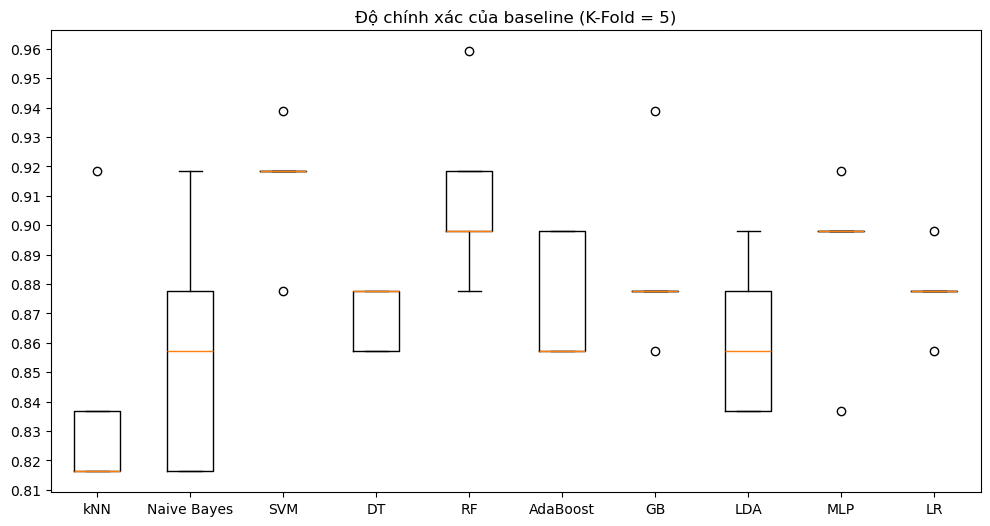

In [12]:
# In biểu đồ box-plot trên độ chính xác với k-fold
import matplotlib.ticker as ticker
plt.figure(figsize=(12,6))
plt.boxplot(baseline_results.values())
plt.gca().set_xticklabels(baseline_results.keys())
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.title(f'Độ chính xác của baseline (K-Fold = {k_fold})')
plt.show()

## Tinh chỉnh mô hình (Tuning Models)

In [13]:
tunning_results = {
    "best_clf"   : {},
    "best_score" : {},
}

tunning_models  = {}
tunning_params  = {}

# khởi tạo các tham số mặc định
# KNN
tunning_models['kNN'] = KNeighborsClassifier()
tunning_params['kNN'] = {
    'n_neighbors': [2, 4, 6, 8, 10],
}

# Naive Bayes
tunning_models['Naive Bayes'] = GaussianNB()
tunning_params['Naive Bayes'] = {
    # GaussianNB không có nhiều tham số để tối ưu
    # Thêm vào đây nếu cần
}

# SVM
tunning_models['SVM'] = SVC(decision_function_shape='ovr',
                            class_weight='balanced',
                            probability=True,
                            random_state=random_state)
tunning_params['SVM'] = {
    'kernel': ['linear', 'rbf'], 
    'C': [1, 10, 100, 200],
    'gamma': [1e-3, 1e-2],
}

# Decision Tree
tunning_models['DT'] = DecisionTreeClassifier(random_state=random_state)
tunning_params['DT'] = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Random Forest
tunning_models['RF'] = RandomForestClassifier(random_state=random_state)
tunning_params['RF'] = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
}

# AdaBoost
tunning_models['AdaBoost'] = AdaBoostClassifier(random_state=random_state)
tunning_params['AdaBoost'] = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
}

# Gradient Boosting
tunning_models['GB'] = GradientBoostingClassifier(random_state=random_state)
tunning_params['GB'] = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 10],
}

# Linear Discriminant Analysis
tunning_models['LDA'] = LinearDiscriminantAnalysis()
tunning_params['LDA'] = {
    'solver': ['svd', 'lsqr', 'eigen'],
}

# MLP Classifier
tunning_models['MLP'] = MLPClassifier(random_state=random_state)
tunning_params['MLP'] = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
}

# Logistic Regression
tunning_models['LR'] = LogisticRegression(random_state=random_state)
tunning_params['LR'] = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
}

for model_name in tunning_models:
    model_clf = tunning_models[model_name]

    print(f'Model [{model_name}]:')

    kfold = KFold(n_splits=k_fold, shuffle=True, random_state=random_state)

    grid_clf = GridSearchCV(estimator=model_clf,
                            param_grid=tunning_params[model_name],
                            cv = kfold, scoring="accuracy")
    grid_result = grid_clf.fit(X_train, y_train)

    # store best model
    tunning_results["best_clf"][model_name] = grid_clf.best_estimator_

    # get search results
    tunning_results["best_score"][model_name] = grid_result.best_score_


    # information
    print(f'+ Best score: {grid_result.best_score_}')
    print(f'+ Best turnning params: {grid_result.best_params_}')
    print(f'+ Best full params: {grid_clf.best_estimator_.get_params()}')
    print()

    pass

Model [kNN]:
+ Best score: 0.9020408163265307
+ Best turnning params: {'n_neighbors': 2}
+ Best full params: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}

Model [Naive Bayes]:
+ Best score: 0.8571428571428573
+ Best turnning params: {}
+ Best full params: {'priors': None, 'var_smoothing': 1e-09}

Model [SVM]:
+ Best score: 0.9061224489795918
+ Best turnning params: {'C': 200, 'gamma': 0.01, 'kernel': 'rbf'}
+ Best full params: {'C': 200, 'break_ties': False, 'cache_size': 200, 'class_weight': 'balanced', 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Model [DT]:
+ Best score: 0.9061224489795918
+ Best turnning params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
+ Best full params: {'ccp_alpha': 0.0, 'class_weigh

## Kiểm nghiệm kết quả trên Test (Finalize Model)
### Load và tiền xử lý tập test

In [14]:
df_test = pd.read_csv('../exps/data/test.csv')
df_test.shape

(105, 35)

In [15]:
df_test.drop( 'attr2', axis=1, inplace=True)

In [16]:
# Standard Encoder
standard_scaler = joblib.load('../exps/feature1/standard_scaler.joblib')
standard_scaler.__dict__

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['attr1', 'attr3', 'attr4', 'attr5', 'attr6', 'attr7', 'attr8',
        'attr9', 'attr10', 'attr11', 'attr12', 'attr13', 'attr14',
        'attr15', 'attr16', 'attr17', 'attr18', 'attr19', 'attr20',
        'attr21', 'attr22', 'attr23', 'attr24', 'attr25', 'attr26',
        'attr27', 'attr28', 'attr29', 'attr30', 'attr31', 'attr32',
        'attr33', 'attr34'], dtype=object),
 'n_features_in_': 33,
 'n_samples_seen_': 245,
 'mean_': array([ 0.89795918,  0.63361514,  0.00756437,  0.61049118,  0.13599947,
         0.54926473,  0.08862498,  0.5062709 ,  0.17184024,  0.47822731,
         0.14488204,  0.40549816,  0.08766143,  0.34170612,  0.05197355,
         0.39237706,  0.00397633,  0.37697686, -0.02657314,  0.34586682,
         0.02264318,  0.37504118, -0.04847327,  0.39990314, -0.06872535,
         0.53589714, -0.05441555,  0.35991171, -0.05634669,  0.33887567,
         0.0096082 ,  0.34748682, -0.0009541

In [17]:

scale_columns = dict(np.load('../exps/feature1/scale_columns.npz', allow_pickle=True))['scale_columns']
print(scale_columns)

['attr1' 'attr3' 'attr4' 'attr5' 'attr6' 'attr7' 'attr8' 'attr9' 'attr10'
 'attr11' 'attr12' 'attr13' 'attr14' 'attr15' 'attr16' 'attr17' 'attr18'
 'attr19' 'attr20' 'attr21' 'attr22' 'attr23' 'attr24' 'attr25' 'attr26'
 'attr27' 'attr28' 'attr29' 'attr30' 'attr31' 'attr32' 'attr33' 'attr34']


In [18]:
# chia dữ liệu thành input/output
X_test, y_test = df_test.values[:, :-1], df_test.values[:, -1].astype(np.int64)

In [19]:
X_test = pca.transform(X_test)

In [20]:
y_test.shape, X_train.shape, y_train.shape

((105,), (245, 10), (245,))

Baseline [kNN]
+ acc = 0.886
[[31  8]
 [ 4 62]]


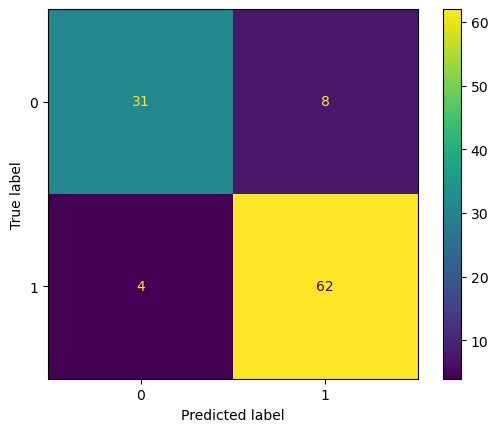

Baseline [Naive Bayes]
+ acc = 0.505
[[39  0]
 [52 14]]


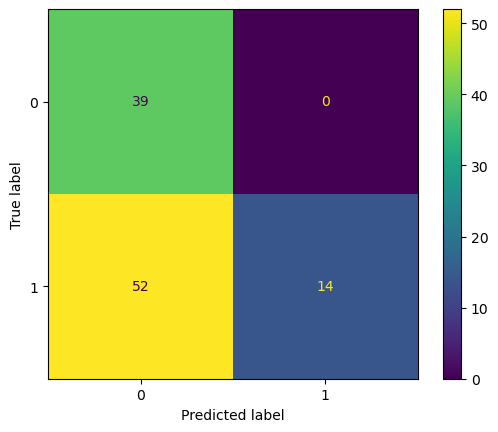

Baseline [SVM]
+ acc = 0.495
[[38  1]
 [52 14]]


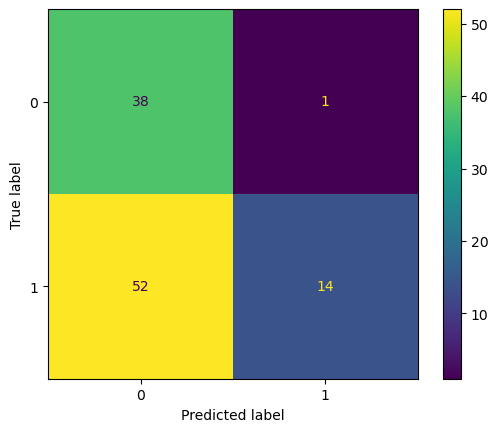

Baseline [DT]
+ acc = 0.524
[[39  0]
 [50 16]]


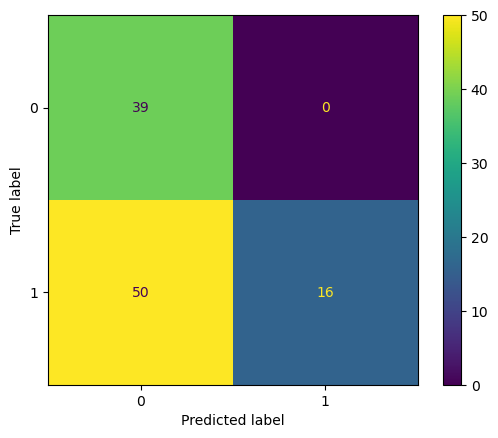

Baseline [RF]
+ acc = 0.638
[[39  0]
 [38 28]]


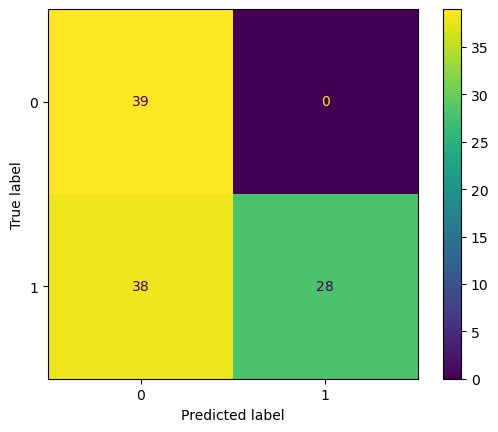

Baseline [AdaBoost]
+ acc = 0.533
[[39  0]
 [49 17]]


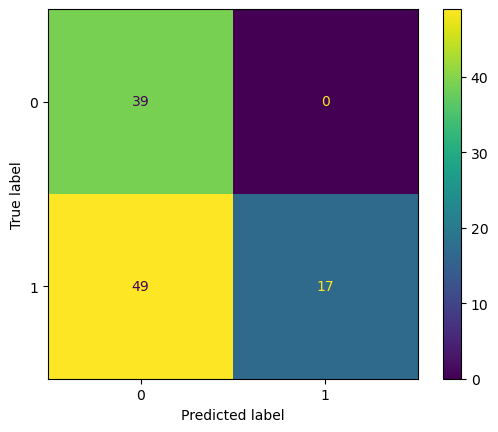

Baseline [GB]
+ acc = 0.600
[[39  0]
 [42 24]]


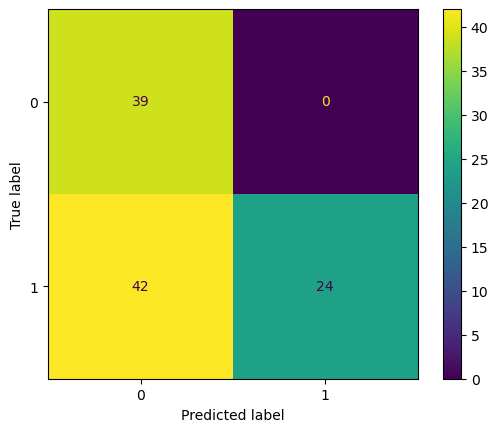

Baseline [LDA]
+ acc = 0.667
[[32  7]
 [28 38]]


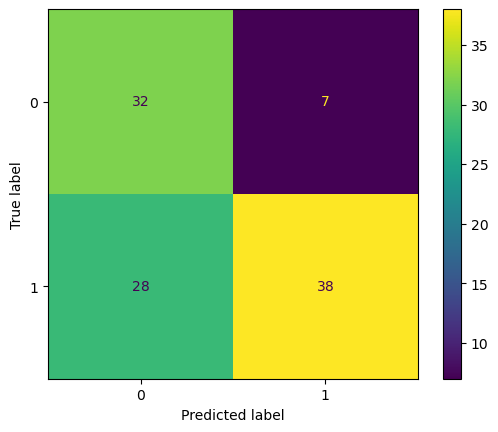

Baseline [MLP]
+ acc = 0.800
[[38  1]
 [20 46]]


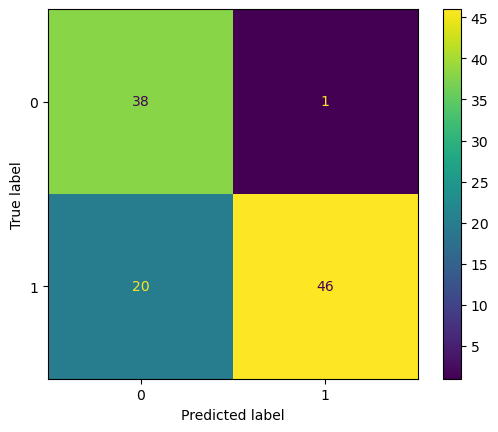

Baseline [LR]
+ acc = 0.638
[[34  5]
 [33 33]]


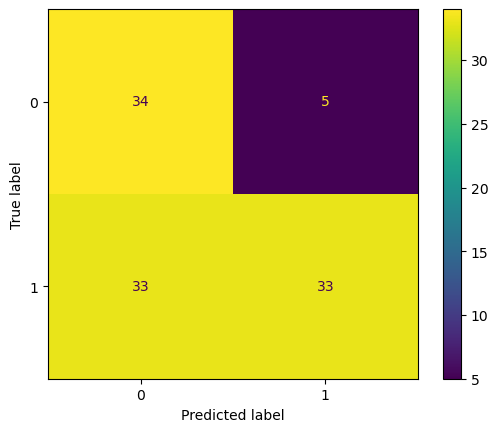

In [21]:
test_models  = {}
test_scores  = {}

# Kiểm tra kết quả trên tập test (baseline)
for model_name in baseline_models:
    model_clf = baseline_models[model_name]
    y_pred_test = model_clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)

    # information
    print(f'Baseline [{model_name}]')
    print(f'+ acc = {test_acc:.3f}')

    cm = confusion_matrix(y_test, y_pred_test)
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    plt.show()

Tunning [kNN]
+ acc = 0.810


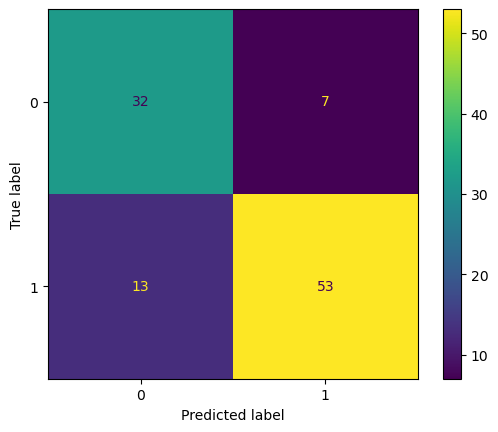

Tunning [Naive Bayes]
+ acc = 0.505


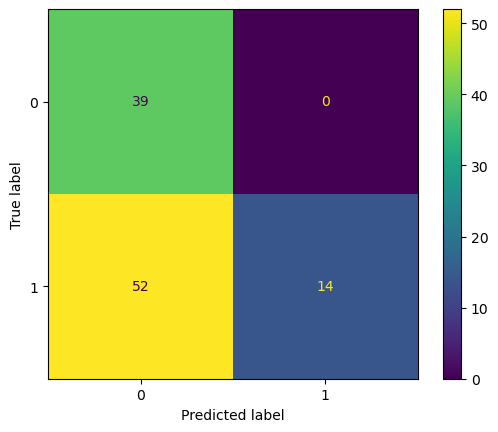

Tunning [SVM]
+ acc = 0.381


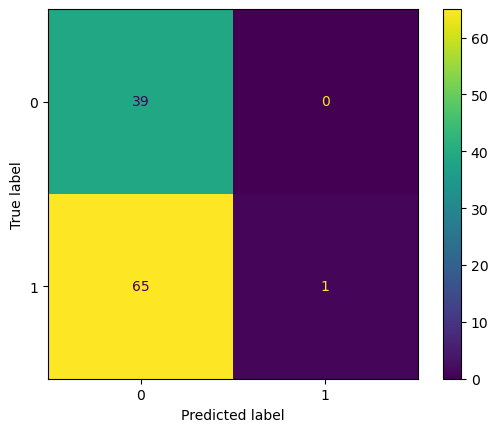

Tunning [DT]
+ acc = 0.590


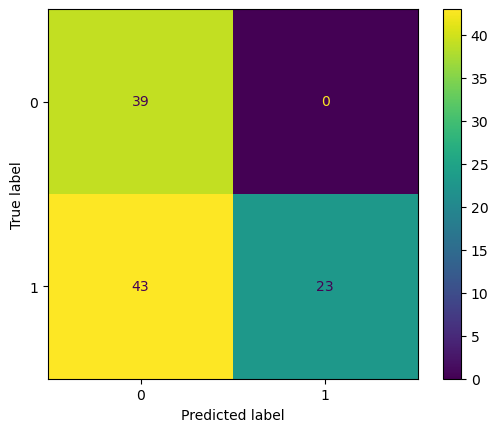

Tunning [RF]
+ acc = 0.705


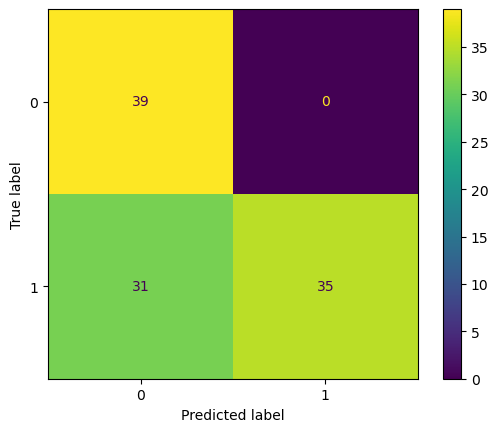

Tunning [AdaBoost]
+ acc = 0.629


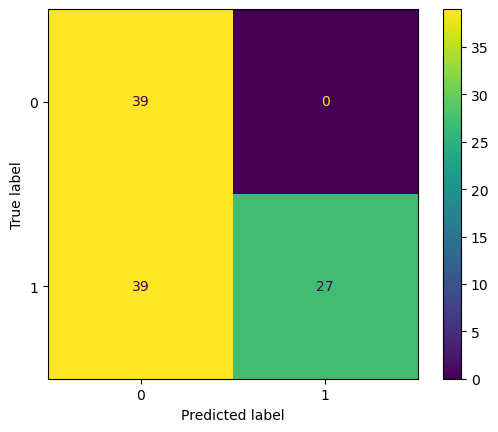

Tunning [GB]
+ acc = 0.686


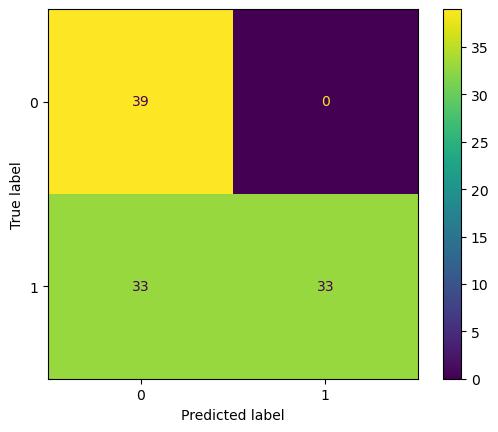

Tunning [LDA]
+ acc = 0.667


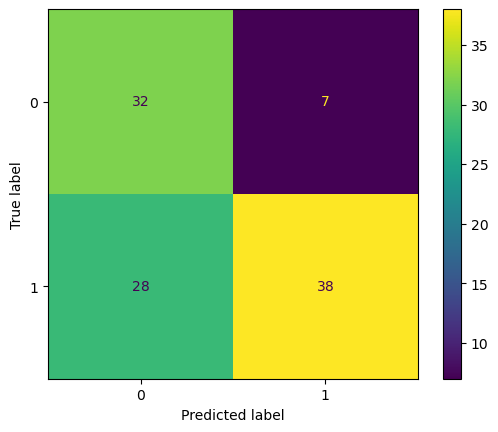

Tunning [MLP]
+ acc = 0.657


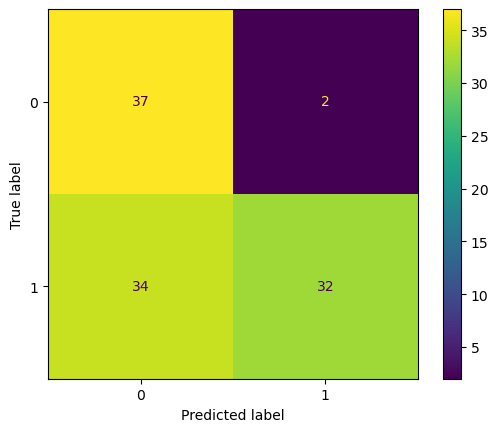

Tunning [LR]
+ acc = 0.638


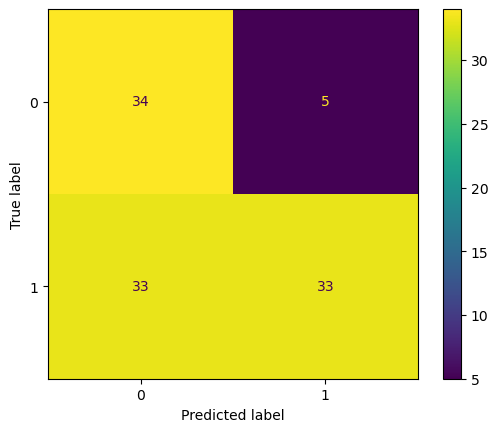

In [22]:
# Kiểm tra kết quả trên tập test (baseline)
for model_name in tunning_models:
    model_clf = tunning_results["best_clf"][model_name]
    y_pred_test = model_clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)

    # information
    print(f'Tunning [{model_name}]')
    print(f'+ acc = {test_acc:.3f}')

    cm = confusion_matrix(y_test, y_pred_test)
    cm

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    plt.show()